# 10. Visualize taxonomy at different taxonomical levels 

In [2]:
library(tidyverse)
library(data.table)
library(reshape2)
library(ggplot2)
library(RColorBrewer)
library(vegan)
library(phyloseq)
library(dplyr) 
library(ggpubr)
library(Hmisc)
library(corrplot)
library(scales)
library(broom)
library(ecodist)
library(patchwork)
library(ggsignif)
library(FSA)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:

In [3]:
## Create color palette
purples <- brewer.pal(n = 5, name = "BuPu")[-c(1:4)] # taking a few colors from the RColorBrewer Package
blues <- rev(brewer.pal(n = 5, name = "Blues")[-1])
greens <- brewer.pal(n = 5, name = "YlGn")[-1]
oranges <- c("#FFEC8B", "#FECC5C", "#fe9a4d", "#fe6f01") # appending some nice oranges, reds, purples, beiges and aquamarines
reds <- c("#b30024", "#ff0033", "#ff554d", "#ff9e99")
purples <- append(purples, c("#ac39ac", "#cc66cc", "#ffb3ff"))
beiges <- c("#999966", "#adad85", "#ccccb3")
aquamarines <- c("#25a696", "#43d6c5", "#96e8df")
pinks <- c("#9F2B68", "#F33A6A")
gray <- c("#808080")
custom_colors <- c(blues, reds, oranges, greens, purples, rev(beiges), aquamarines, pinks) # combinig all colors in a single vector

In [4]:
# Load data
setwd("/home/strawberry/Documents/Collaborations/sinusite_edwin/data")

ReadCounts_TaxAnnotation <- read.delim("./ReadCounts_TaxAnnotation_SILVA.tsv")
metadata_filtered <- read.delim("./metadata_filtered_Diversity.tsv")

print(head(ReadCounts_TaxAnnotation))
print(head(metadata_filtered))

    ID_Sample           id count  Kingdom         Phylum          Class
1 0001967K_T1     AB646616     1 Bacteria      Bacillota        Bacilli
2 0001967K_T1     AF015929     4 Bacteria      Bacillota        Bacilli
3 0001967K_T1 AGEF01000005     1 Bacteria      Bacillota        Bacilli
4 0001967K_T1 AIYD01000002     2 Bacteria      Bacillota        Bacilli
5 0001967K_T1     AJ439343     1 Bacteria Actinomycetota Actinobacteria
6 0001967K_T1     AJ938182     1 Bacteria      Bacillota        Bacilli
             Order             Family           Genus
1 Staphylococcales  Staphylococcaceae  Staphylococcus
2 Staphylococcales  Staphylococcaceae  Staphylococcus
3  Lactobacillales  Carnobacteriaceae  Dolosigranulum
4 Staphylococcales  Staphylococcaceae  Staphylococcus
5  Mycobacteriales Corynebacteriaceae Corynebacterium
6 Staphylococcales  Staphylococcaceae  Staphylococcus
                               Species total_aligned RelativeAbundance SNOT22
1       Staphylococcus saccharolyticus  

In [5]:
# colnames(ReadCounts_TaxAnnotation)
# colnames(metadata_filtered)

Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


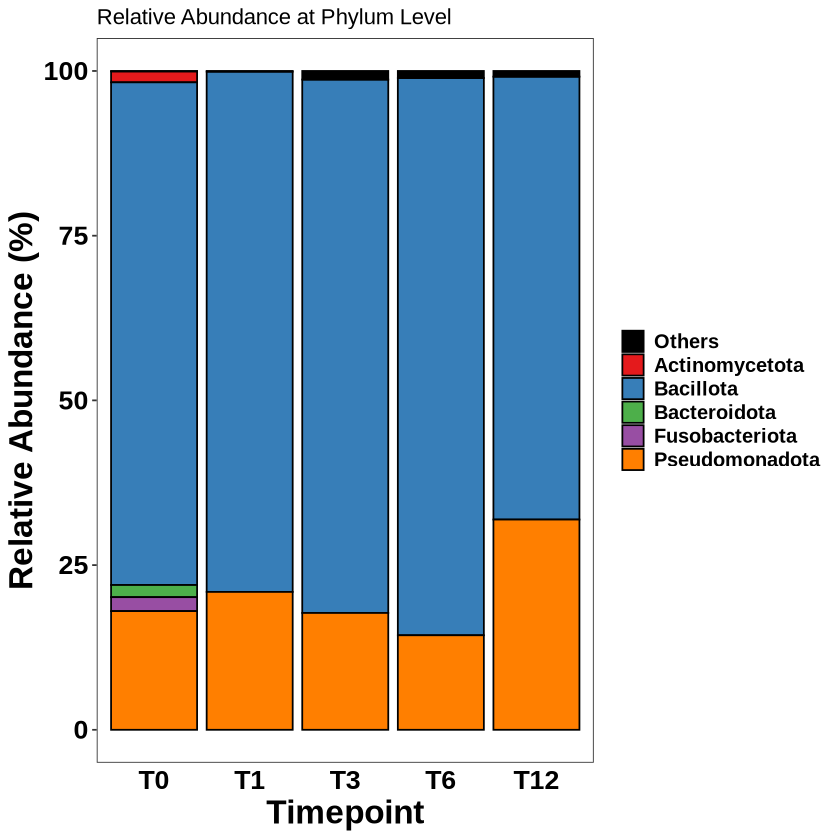

Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


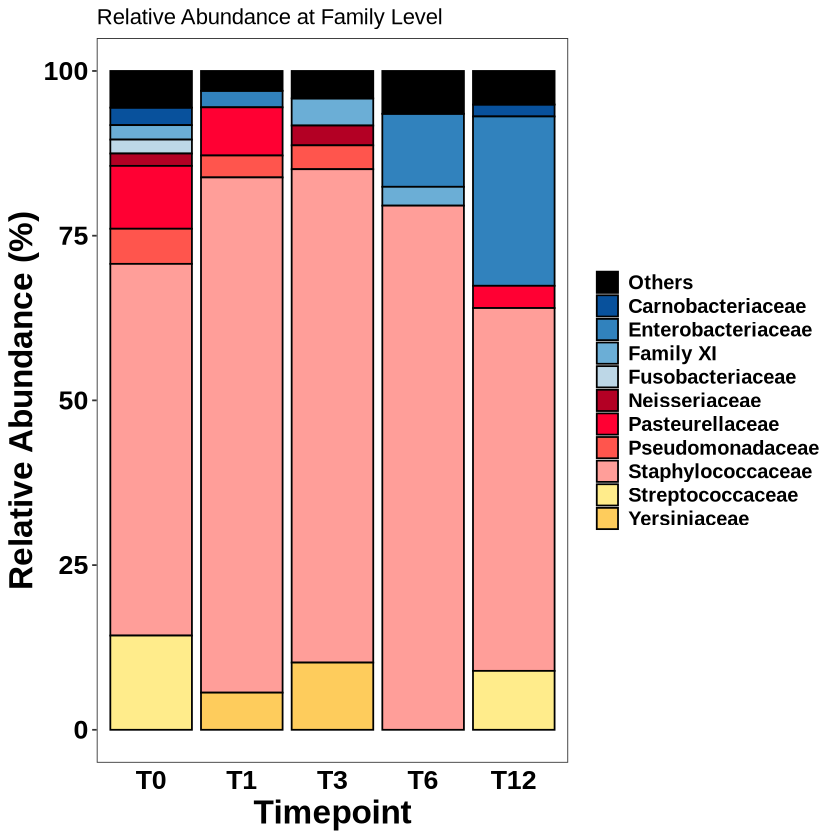

Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


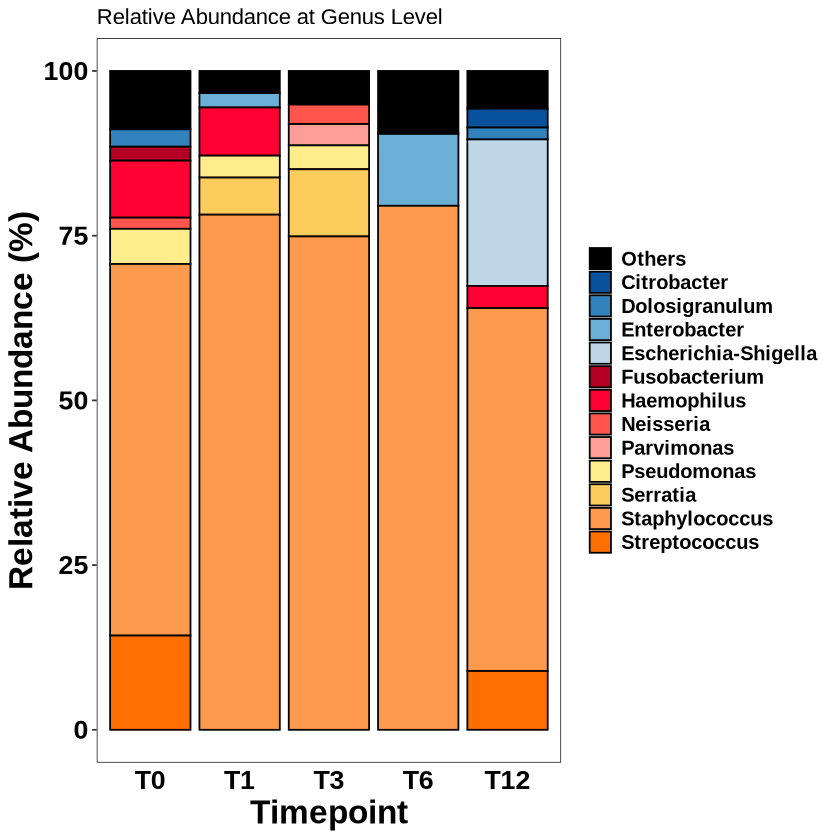

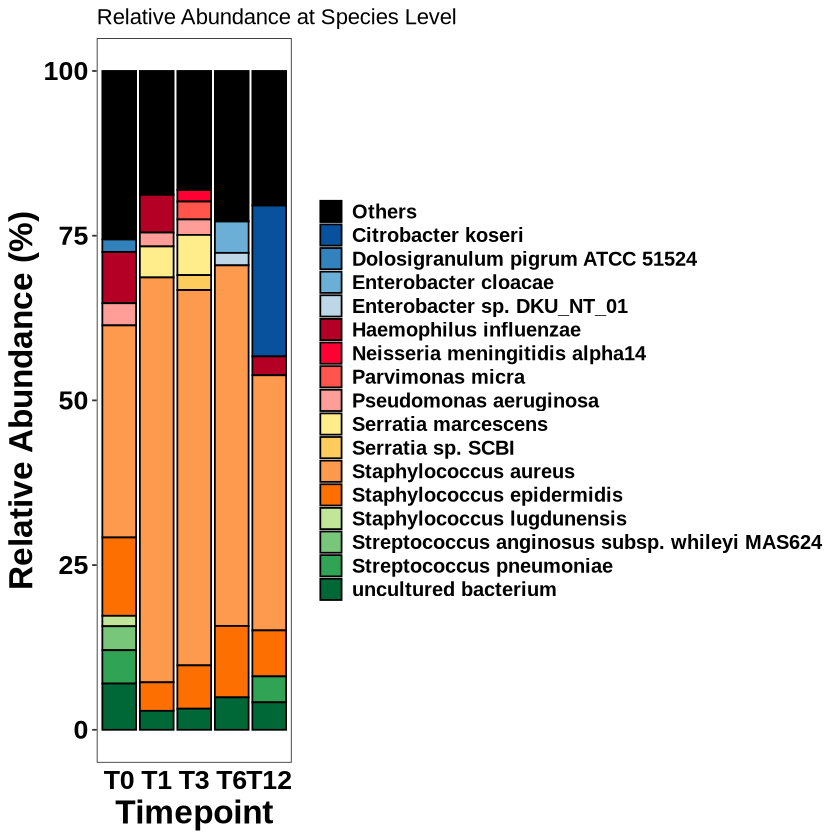

In [6]:
# Define function to process and plot relative abundance at different taxonomy levels
plot_relative_abundance <- function(data, tax_level, output_file) {
  
  # Aggregate counts at the specified taxonomic level
  df_tax <- aggregate(data$count, 
                      list(data[[tax_level]], data$ID_Sample, data$Timepoint), 
                      FUN=sum)
  colnames(df_tax) <- c("Taxa", "ID_Sample", "Timepoint", "Counts")

  # Create relative abundance data
  cast_data_tax <- acast(df_tax, Timepoint ~ Taxa, value.var = "Counts", fun.aggregate = sum)
  cast_data_tax[is.na(cast_data_tax)] <- 0  # Replace missing values with 0

  # Calculating relative abundance
  tcast_data_tax <- t(cast_data_tax)
  relative_abundance_tax <- (t(tcast_data_tax) / apply(tcast_data_tax, 2, sum)) * 100
  df_relab_tax <- melt(relative_abundance_tax) # Reshape data frame

  # Rename columns
  colnames(df_relab_tax) <- c("Timepoint", "Taxa", "RelativeAbundance") 
  df_relab_tax <- df_relab_tax[-which(df_relab_tax$RelativeAbundance == 0),] # Remove rows with zero relative abundance

  # Filter taxa above threshold (e.g., 1.5%)
  df_relab_tax_filt <- subset(df_relab_tax, RelativeAbundance > 1.5)

  # Compute "Others" category to ensure bars reach 100%
  df_sum <- df_relab_tax_filt %>%
    group_by(Timepoint) %>%
    summarise(TotalAbundance = sum(RelativeAbundance))

  df_others <- df_sum %>%
    mutate(Taxa = "Others", 
           RelativeAbundance = 100 - TotalAbundance) %>%
    select(Timepoint, Taxa, RelativeAbundance)

  df_relab_tax_filt <- rbind(df_relab_tax_filt, df_others)

  # Order Timepoints
  df_relab_tax_filt$Timepoint <- factor(df_relab_tax_filt$Timepoint, levels = c("T0", "T1", "T3", "T6", "T12"))

  df_relab_tax_filt <- df_relab_tax_filt %>%
    mutate(Taxa = factor(Taxa, levels = c(setdiff(unique(Taxa), "Others"), "Others")))

  ## Assign colors to taxa, ensuring 'Others' is always black
  unique_taxa <- setdiff(unique(df_relab_tax_filt$Taxa), "Others")

    # Choose palette: custom for Phylum, otherwise use pre-defined custom_colors
    if (tax_level == "Phylum") {
      # Use Set1 from RColorBrewer for high-contrast phylum colors
      n_colors <- length(unique_taxa)
      phylum_colors <- RColorBrewer::brewer.pal(min(max(n_colors, 3), 9), "Set1")
      color_palette <- setNames(phylum_colors[seq_along(unique_taxa)], unique_taxa)
    } else {
      color_palette <- setNames(custom_colors[seq_along(unique_taxa)], unique_taxa)
}

color_palette["Others"] <- "black"  # Always set Others to black
  # Create the plot
  tax_plot <- ggplot(data = df_relab_tax_filt, 
                      aes(x = Timepoint, 
                          y = RelativeAbundance, 
                          fill = factor(Taxa, levels = c("Others", setdiff(unique(df_relab_tax_filt$Taxa), "Others"))))) + 
    geom_bar(stat = "identity", position = "stack", colour = "black") +
    scale_fill_manual(values = color_palette) + 
    labs(x = "Timepoint", y = "Relative Abundance (%)", title = paste("Relative Abundance at", tax_level, "Level")) +
    theme_bw() +
    theme(axis.title.x = element_text(size = 20, face = "bold", color = "black"),
          axis.text.x = element_text(size = 16, face = "bold", color = "black"),
          axis.title.y = element_text(size = 20, face = "bold", color = "black"),
          axis.text.y = element_text(size = 16, face = "bold", color = "black"),
          strip.text.x = element_text(size = 16, face = "bold", color = "black"),
          legend.title = element_blank(),
          legend.text = element_text(size = 12, face = "bold"),
          axis.ticks.x = element_blank(),
          strip.background = element_rect(fill = "white"),
          panel.grid = element_blank(),
          legend.position = "right") +
    theme(legend.key.size = unit(0.5, "cm")) +  
    guides(fill = guide_legend(ncol = 1))  # Legend in one column

  # Save the plot
  ggsave(output_file, plot = tax_plot, width = 10, height = 6, dpi = 300)
  
  return(tax_plot)
}

# Generate and save plots
plot_relative_abundance(ReadCounts_TaxAnnotation, "Phylum", "Phylum_Relative_Abundance.png")
plot_relative_abundance(ReadCounts_TaxAnnotation, "Family", "Family_Relative_Abundance.png")
plot_relative_abundance(ReadCounts_TaxAnnotation, "Genus", "Genus_Relative_Abundance.png")
plot_relative_abundance(ReadCounts_TaxAnnotation, "Species", "Species_Relative_Abundance.png")

Warning message:
“Use of `df_relab_species_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


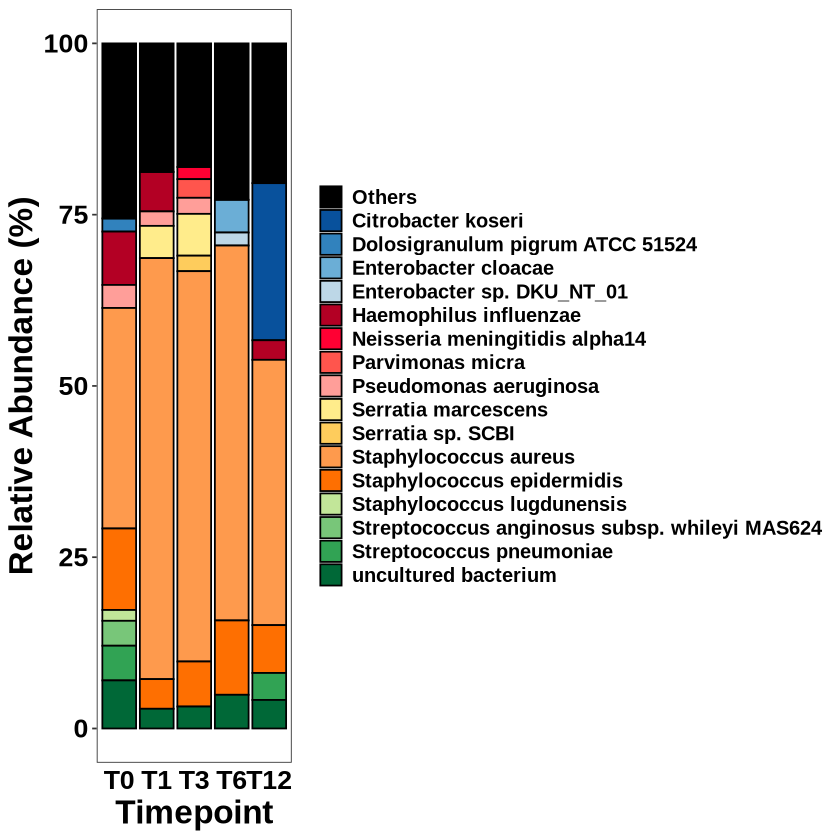

In [7]:
# Species-Level Relative Abundance Plot
# Aggregate counts at the species level
df_species <- aggregate(ReadCounts_TaxAnnotation$count, 
                       list(ReadCounts_TaxAnnotation$Species, ReadCounts_TaxAnnotation$ID_Sample, ReadCounts_TaxAnnotation$Timepoint), 
                       FUN=sum) 
colnames(df_species) <- c("Taxa", "ID_Sample", "Timepoint", "Counts")

# Create relative abundance data
cast_data_species = acast(df_species, Timepoint ~ Taxa, value.var = "Counts", fun.aggregate = sum)
cast_data_species[is.na(cast_data_species)] <- 0 # Replace missing values with 0

# Calculating relative abundance
tcast_data_species <- t(cast_data_species)
relative_abundance_species <- (t(tcast_data_species) / apply(tcast_data_species, 2, sum)) * 100
df_relab_species <- melt(relative_abundance_species) # Reshape data frame

# Rename columns
colnames(df_relab_species) <- c("Timepoint", "Taxa", "RelativeAbundance") 
df_relab_species <- df_relab_species[-which(df_relab_species$RelativeAbundance == 0),] # Remove rows with zero relative abundance

# Filter taxa above threshold (1.5%)
df_relab_species_filt <- subset(df_relab_species, RelativeAbundance > 1.5)

# Compute "Others"
df_sum <- df_relab_species_filt %>%
    group_by(Timepoint) %>%
    summarise(TotalAbundance = sum(RelativeAbundance))

df_others <- df_sum %>%
    mutate(Taxa = "Others", RelativeAbundance = 100 - TotalAbundance) %>%
    select(Timepoint, Taxa, RelativeAbundance)

df_relab_species_filt <- bind_rows(df_relab_species_filt, df_others)

# Order factors
df_relab_species_filt$Timepoint <- factor(df_relab_species_filt$Timepoint, levels = c("T0", "T1", "T3", "T6", "T12"))

df_relab_species_filt <- df_relab_species_filt %>%
  mutate(Taxa = factor(Taxa, levels = c(setdiff(unique(Taxa), "Others"), "Others")))

# Define custom color palette
purples <- brewer.pal(n = 5, name = "BuPu")[-c(1:4)]
blues <- rev(brewer.pal(n = 5, name = "Blues")[-1])
greens <- brewer.pal(n = 5, name = "YlGn")[-1]
oranges <- c("#FFEC8B", "#FECC5C", "#fe9a4d", "#fe6f01")
reds <- c("#b30024", "#ff0033", "#ff554d", "#ff9e99")
purples <- append(purples, c("#ac39ac", "#cc66cc", "#ffb3ff"))
beiges <- c("#999966", "#adad85", "#ccccb3")
aquamarines <- c("#25a696", "#43d6c5", "#96e8df")
pinks <- c("#9F2B68", "#F33A6A")
gray <- c("#808080")
custom_colors <- c(blues, reds, oranges, greens, purples, rev(beiges), aquamarines, pinks)

# Assign colors to taxa
unique_taxa <- setdiff(unique(df_relab_species_filt$Taxa), "Others")
color_palette <- setNames(custom_colors[seq_along(unique_taxa)], unique_taxa)
color_palette["Others"] <- "black"

# Plot
species_plot <- ggplot(data = df_relab_species_filt, 
                      aes(x = Timepoint, y = RelativeAbundance, 
                          fill = factor(Taxa, levels = c("Others", setdiff(unique(df_relab_species_filt$Taxa), "Others"))))) + 
    geom_bar(stat = "identity", position = "stack", colour = "black") +
    scale_fill_manual(values = color_palette) + 
    labs(x = "Timepoint", y = "Relative Abundance (%)") +
    theme_bw() +
    theme(axis.title.x = element_text(size = 20, face = "bold", color = "black"),
          axis.text.x = element_text(size = 16, face = "bold", color = "black"),
          axis.title.y = element_text(size = 20, face = "bold", color = "black"),
          axis.text.y = element_text(size = 16, face = "bold", color = "black"),
          strip.text.x = element_text(size = 16, face = "bold", color = "black"),
          legend.title = element_blank(),
          legend.text = element_text(size = 12, face = "bold"),
          axis.ticks.x = element_blank(),
          strip.background = element_rect(fill = "white"),
          panel.grid = element_blank(),
          legend.position = "right") +
    theme(legend.key.size = unit(0.5, "cm")) + # adjust legend key size
    guides(fill = guide_legend(ncol = 1))  # Force legend into one column
species_plot

In [8]:
print(head(df_species))

                            Taxa   ID_Sample Timepoint Counts
1 [Propionibacterium] namnetense 0088303G_T0        T0      1
2          Anaerococcus octavius 0088303G_T0        T0      4
3                      bacterium 0088303G_T0        T0      8
4              bacterium 1-gw1-3 0088303G_T0        T0      9
5               bacterium HKG213 0088303G_T0        T0     16
6                  bacterium N47 0088303G_T0        T0     21


In [9]:
# Species-Level Relative Abundance Plot: Staphyloccoci

## Filter to only Staphylococcus species
staph_species_data <- ReadCounts_TaxAnnotation %>%
  filter(grepl("^Staphylococcus", Species))
print(head(staph_species_data))

    ID_Sample           id count  Kingdom    Phylum   Class            Order
1 0001967K_T1     AB646616     1 Bacteria Bacillota Bacilli Staphylococcales
2 0001967K_T1     AF015929     4 Bacteria Bacillota Bacilli Staphylococcales
3 0001967K_T1 AIYD01000002     2 Bacteria Bacillota Bacilli Staphylococcales
4 0001967K_T1     AJ938182     1 Bacteria Bacillota Bacilli Staphylococcales
5 0001967K_T1     AJ938182     1 Bacteria Bacillota Bacilli Staphylococcales
6 0001967K_T1     AJ938182     1 Bacteria Bacillota Bacilli Staphylococcales
             Family          Genus                        Species total_aligned
1 Staphylococcaceae Staphylococcus Staphylococcus saccharolyticus           670
2 Staphylococcaceae Staphylococcus          Staphylococcus aureus           670
3 Staphylococcaceae Staphylococcus    Staphylococcus aureus M1016           670
4 Staphylococcaceae Staphylococcus    Staphylococcus aureus RF122           670
5 Staphylococcaceae Staphylococcus    Staphylococcus aureus R

Warning message:
“Use of `df_relab_staph_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


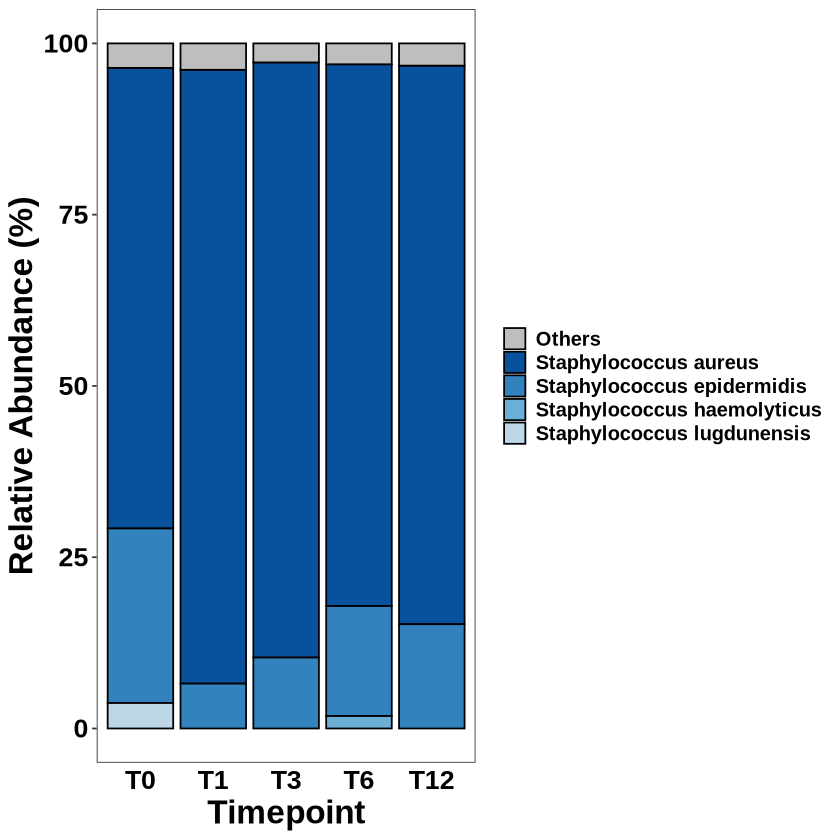

In [10]:
## Collapse species lineages to genus + species (first two words)
staph_species_data$Collapsed_Species <- gsub("^([A-Za-z]+\\s+[a-z]+).*", "\\1", staph_species_data$Species)

## Aggregate counts at the species level
df_species_staph <- aggregate(staph_species_data$count, 
                              list(staph_species_data$Collapsed_Species,
                                   staph_species_data$ID_Sample,
                                   staph_species_data$Timepoint), 
                              FUN = sum)
colnames(df_species_staph) <- c("Taxa", "ID_Sample", "Timepoint", "Counts")

## Create relative abundance data
cast_data_staph = acast(df_species_staph, Timepoint ~ Taxa, value.var = "Counts", fun.aggregate = sum)
cast_data_staph[is.na(cast_data_staph)] <- 0

## Calculate relative abundance
tcast_data_staph <- t(cast_data_staph)
relative_abundance_staph <- (t(tcast_data_staph) / apply(tcast_data_staph, 2, sum)) * 100
df_relab_staph <- melt(relative_abundance_staph)

colnames(df_relab_staph) <- c("Timepoint", "Taxa", "RelativeAbundance")
df_relab_staph <- df_relab_staph[df_relab_staph$RelativeAbundance > 0, ]

## Optional: Filter taxa above a threshold (e.g., 1.5%)
df_relab_staph_filt <- subset(df_relab_staph, RelativeAbundance > 1.5)

## Compute "Others"
df_sum_staph <- df_relab_staph_filt %>%
  group_by(Timepoint) %>%
  summarise(TotalAbundance = sum(RelativeAbundance))

df_others_staph <- df_sum_staph %>%
  mutate(Taxa = "Others", RelativeAbundance = 100 - TotalAbundance) %>%
  select(Timepoint, Taxa, RelativeAbundance)

df_relab_staph_filt <- bind_rows(df_relab_staph_filt, df_others_staph)

## Set factor levels
df_relab_staph_filt$Timepoint <- factor(df_relab_staph_filt$Timepoint, levels = c("T0", "T1", "T3", "T6", "T12"))
df_relab_staph_filt <- df_relab_staph_filt %>%
  mutate(Taxa = factor(Taxa, levels = c(setdiff(unique(Taxa), "Others"), "Others")))

## Assign colors
unique_taxa_staph <- setdiff(unique(df_relab_staph_filt$Taxa), "Others")
color_palette_staph <- setNames(custom_colors[seq_along(unique_taxa_staph)], unique_taxa_staph)
color_palette_staph["Others"] <- "gray"

## Plot
staph_plot <- ggplot(data = df_relab_staph_filt, 
                     aes(x = Timepoint, y = RelativeAbundance, 
                         fill = factor(Taxa, levels = c("Others", setdiff(unique(df_relab_staph_filt$Taxa), "Others"))))) + 
  geom_bar(stat = "identity", position = "stack", colour = "black") +
  scale_fill_manual(values = color_palette_staph) + 
  labs(x = "Timepoint", y = "Relative Abundance (%)") +
  theme_bw() +
  theme(axis.title.x = element_text(size = 20, face = "bold", color = "black"),
        axis.text.x = element_text(size = 16, face = "bold", color = "black"),
        axis.title.y = element_text(size = 20, face = "bold", color = "black"),
        axis.text.y = element_text(size = 16, face = "bold", color = "black"),
        strip.text.x = element_text(size = 16, face = "bold", color = "black"),
        legend.title = element_blank(),
        legend.text = element_text(size = 12, face = "bold"),
        axis.ticks.x = element_blank(),
        strip.background = element_rect(fill = "white"),
        panel.grid = element_blank(),
        legend.position = "right") +
  theme(legend.key.size = unit(0.5, "cm")) +
  guides(fill = guide_legend(ncol = 1)) 

staph_plot

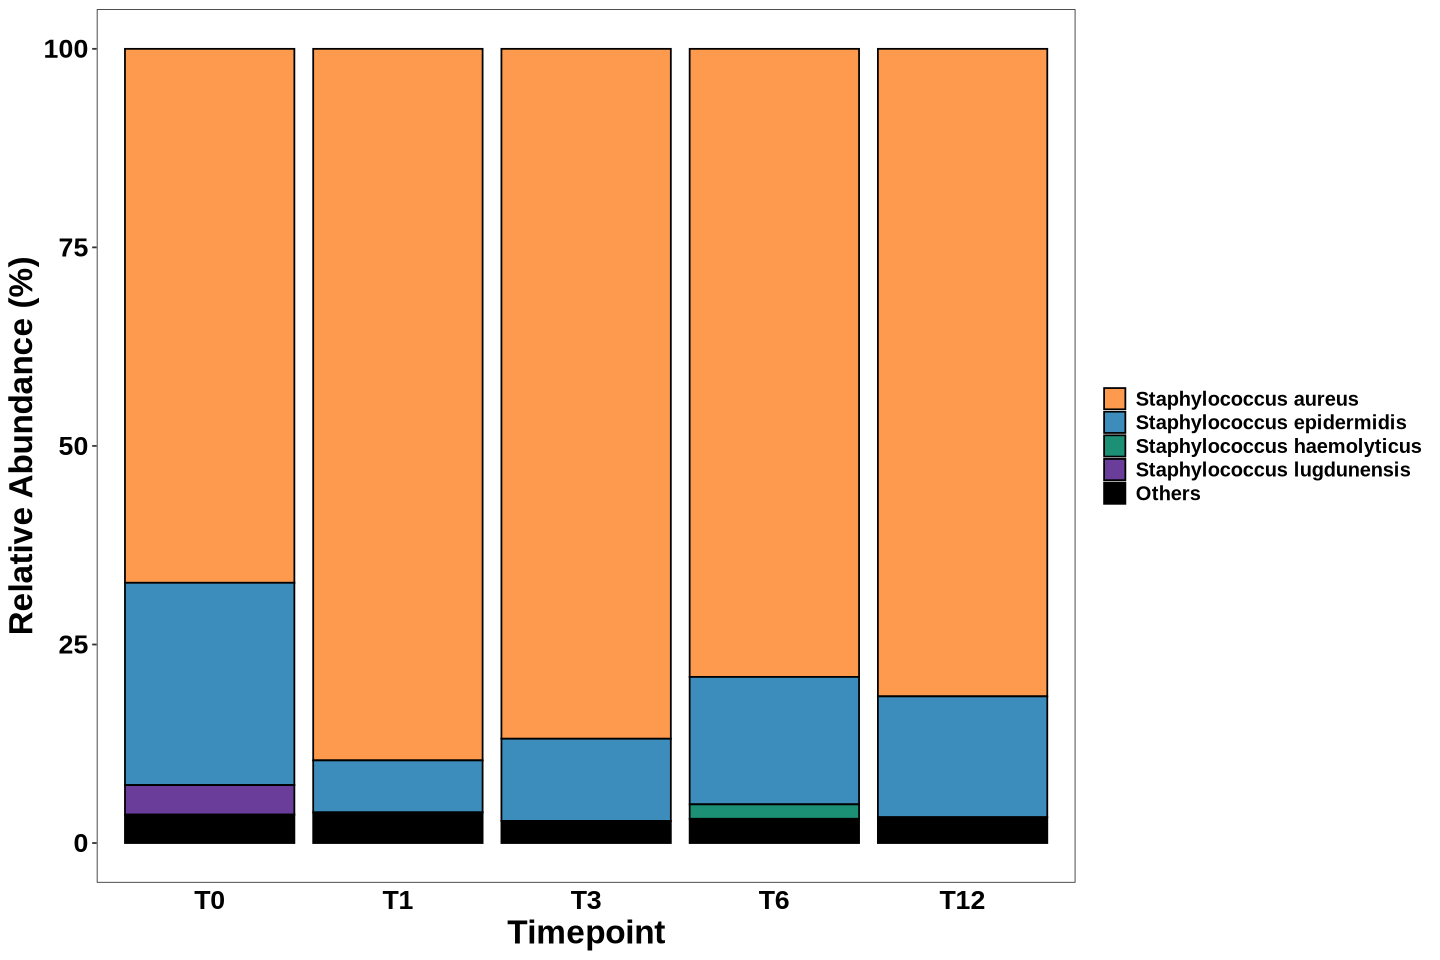

In [11]:
# Make the same Staphylococcus plot, but using shades of the same color for differenciating between CoPS and CoNS
## Define your groups
cop_species <- c("Staphylococcus aureus") #, "Staphylococcus argenteus", "Staphylococcus roterodami", "Staphylococcus schweitzeri")
cons_species <- c("Staphylococcus epidermidis", "Staphylococcus lugdunensis", "Staphylococcus haemolyticus")

# Color palettes
cop_colors <- c("#fe9a4d")
cons_colors <- c("#3C8DBC", "#6A3D9A", "#1C9075")

# Filter taxa (excluding "Others") for coloring
taxa_to_color <- setdiff(unique(df_relab_staph_filt$Taxa), "Others")

# Create named color vector
color_palette_staph <- sapply(taxa_to_color, function(taxa) {
  if (taxa %in% cop_species) {
    return(cop_colors[which(cop_species == taxa)])
  } else if (taxa %in% cons_species) {
    return(cons_colors[which(cons_species == taxa)])
  } else {
    return("#999999") # fallback for unknown taxa
  }
})
color_palette_staph["Others"] <- "black"

df_relab_staph_filt <- df_relab_staph_filt %>%
  mutate(Taxa = factor(Taxa, levels = c(setdiff(unique(Taxa), "Others"), "Others")))

staph_plot <- ggplot(data = df_relab_staph_filt, 
                     aes(x = Timepoint, y = RelativeAbundance, fill = Taxa)) + 
  geom_bar(stat = "identity", position = "stack", colour = "black") +
  scale_fill_manual(values = color_palette_staph) +
  labs(x = "Timepoint", y = "Relative Abundance (%)") +
  theme_bw() +
  theme(axis.title.x = element_text(size = 20, face = "bold", color = "black"),
        axis.text.x = element_text(size = 16, face = "bold", color = "black"),
        axis.title.y = element_text(size = 20, face = "bold", color = "black"),
        axis.text.y = element_text(size = 16, face = "bold", color = "black"),
        strip.text.x = element_text(size = 16, face = "bold", color = "black"),
        legend.title = element_blank(),
        legend.text = element_text(size = 12, face = "bold"),
        axis.ticks.x = element_blank(),
        strip.background = element_rect(fill = "white"),
        panel.grid = element_blank(),
        legend.position = "right") +
  theme(legend.key.size = unit(0.5, "cm")) +
  guides(fill = guide_legend(ncol = 1))

options(repr.plot.width = 12, repr.plot.height = 8)

staph_plot

In [12]:
ggsave("staphspp_plot_relabund.png", plot = staph_plot, width = 10, height = 6, dpi = 300)

In [26]:
print(head(df_relab_staph_filt))

  Timepoint                       Taxa RelativeAbundance
1        T0      Staphylococcus aureus          67.23164
2        T1      Staphylococcus aureus          89.59701
3       T12      Staphylococcus aureus          81.53459
4        T3      Staphylococcus aureus          86.86858
5        T6      Staphylococcus aureus          79.08337
6        T0 Staphylococcus epidermidis          25.47533


In [25]:
write.table(df_relab_staph_filt, file = "df_relab_staph_filt.tsv", quote = FALSE, sep = "\t", row.names = F)

In [13]:
# Plot changes in the relative abundance of specific genus across timepoints
#### Staphylococcus

## Ensure ordered timepoints
df_species$Timepoint <- factor(df_species$Timepoint, levels = c("T0", "T1", "T3", "T6", "T12"))

## Extract only the Genus (first word of Taxa)
df_species <- df_species %>%
  mutate(Genus = word(Taxa, 1))  # or: str_extract(Taxa, "^\\S+")

## Recalculate relative abundance per sample (based on original Counts)
df_species <- df_species %>%
  group_by(ID_Sample) %>%
  mutate(RelAbund = Counts / sum(Counts) * 100) %>%
  ungroup()

head(df_species)

## Filter for Genus: Staphylococcus
df_staph <- df_species %>%
  filter(Genus == "Staphylococcus")
head(df_staph) 

## Sum relative abundance per sample across all Staph species
df_staph_genus <- df_staph %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")
head(df_staph_genus) 

## Compute timepoint-wise mean
means_staph <- df_staph_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Define pairwise comparisons
my_comparisons <- list(
  c("T0", "T1"), c("T0", "T3"), c("T0", "T6"), c("T0", "T12"),
  c("T1", "T3"), c("T1", "T6"), c("T1", "T12"),
  c("T3", "T6"), c("T3", "T12"),
  c("T6", "T12")
)

Taxa,ID_Sample,Timepoint,Counts,Genus,RelAbund
<chr>,<chr>,<fct>,<int>,<chr>,<dbl>
[Propionibacterium] namnetense,0088303G_T0,T0,1,[Propionibacterium],0.01600512
Anaerococcus octavius,0088303G_T0,T0,4,Anaerococcus,0.06402049
bacterium,0088303G_T0,T0,8,bacterium,0.12804097
bacterium 1-gw1-3,0088303G_T0,T0,9,bacterium,0.14404609
bacterium HKG213,0088303G_T0,T0,16,bacterium,0.25608195
bacterium N47,0088303G_T0,T0,21,bacterium,0.33610755


Taxa,ID_Sample,Timepoint,Counts,Genus,RelAbund
<chr>,<chr>,<fct>,<int>,<chr>,<dbl>
Staphylococcus aureus,0088303G_T0,T0,105,Staphylococcus,1.68053777
Staphylococcus aureus subsp. anaerobius,0088303G_T0,T0,1,Staphylococcus,0.01600512
Staphylococcus aureus subsp. aureus Tager 104,0088303G_T0,T0,7,Staphylococcus,0.11203585
Staphylococcus capitis,0088303G_T0,T0,216,Staphylococcus,3.45710627
Staphylococcus capitis subsp. urealyticus,0088303G_T0,T0,2,Staphylococcus,0.03201024
Staphylococcus caprae,0088303G_T0,T0,26,Staphylococcus,0.41613316


ID_Sample,Timepoint,RelAbund
<chr>,<fct>,<dbl>
0001967K_T1,T1,96.63290
0001967K_T3,T3,98.38821
0001967K_T6,T6,98.81448
0088303G_T0,T0,62.82010
0088303G_T1,T1,98.49397
0088303G_T3,T3,79.26682


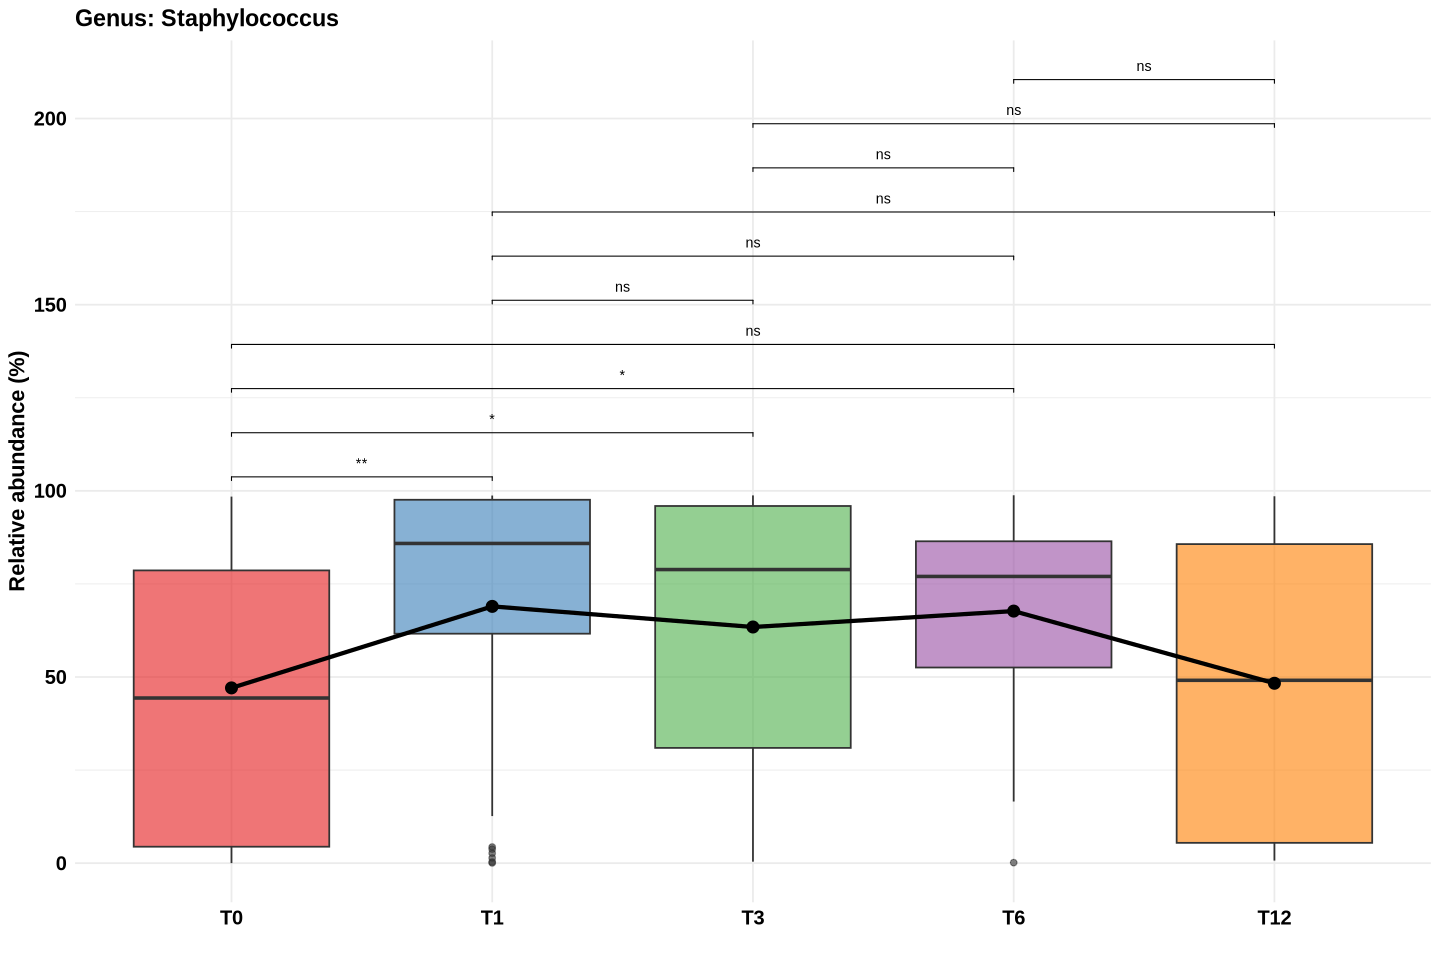

In [42]:
## Plot Staphylococcus spp.
p_staph_genus <- ggplot(df_staph_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_staph, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_staph, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  stat_compare_means(
    comparisons = my_comparisons,
    method = "wilcox.test",
    p.adjust.method = "bonferroni",
    label = "p.signif",
    tip.length = 0.01,
    size = 3
  ) +
  theme_minimal() +
  labs(
    title = "Genus: Staphylococcus",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )

p_staph_genus

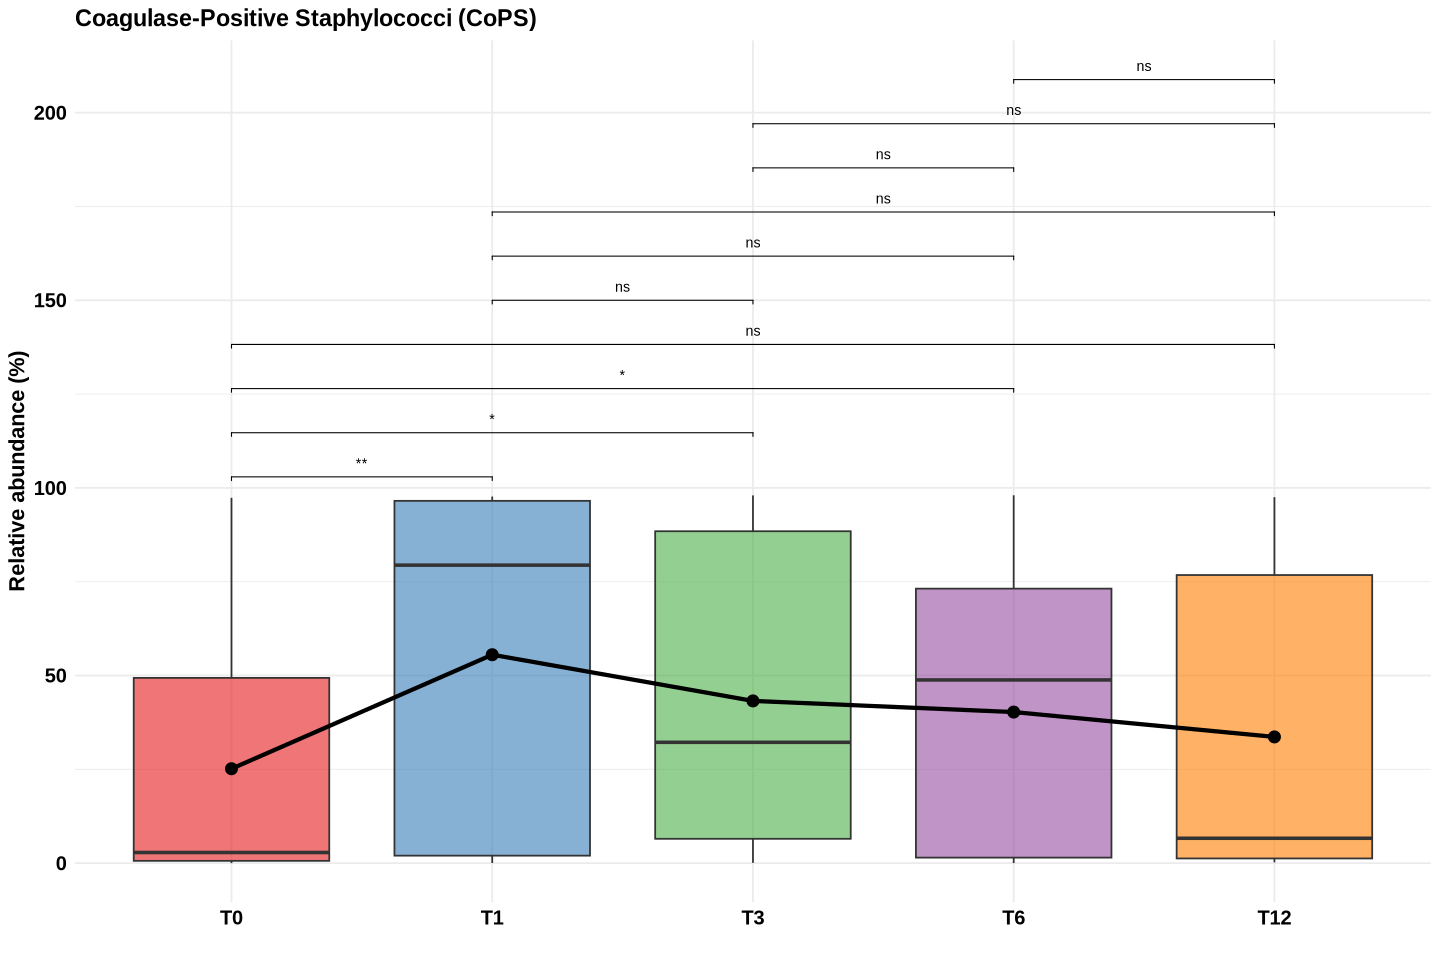

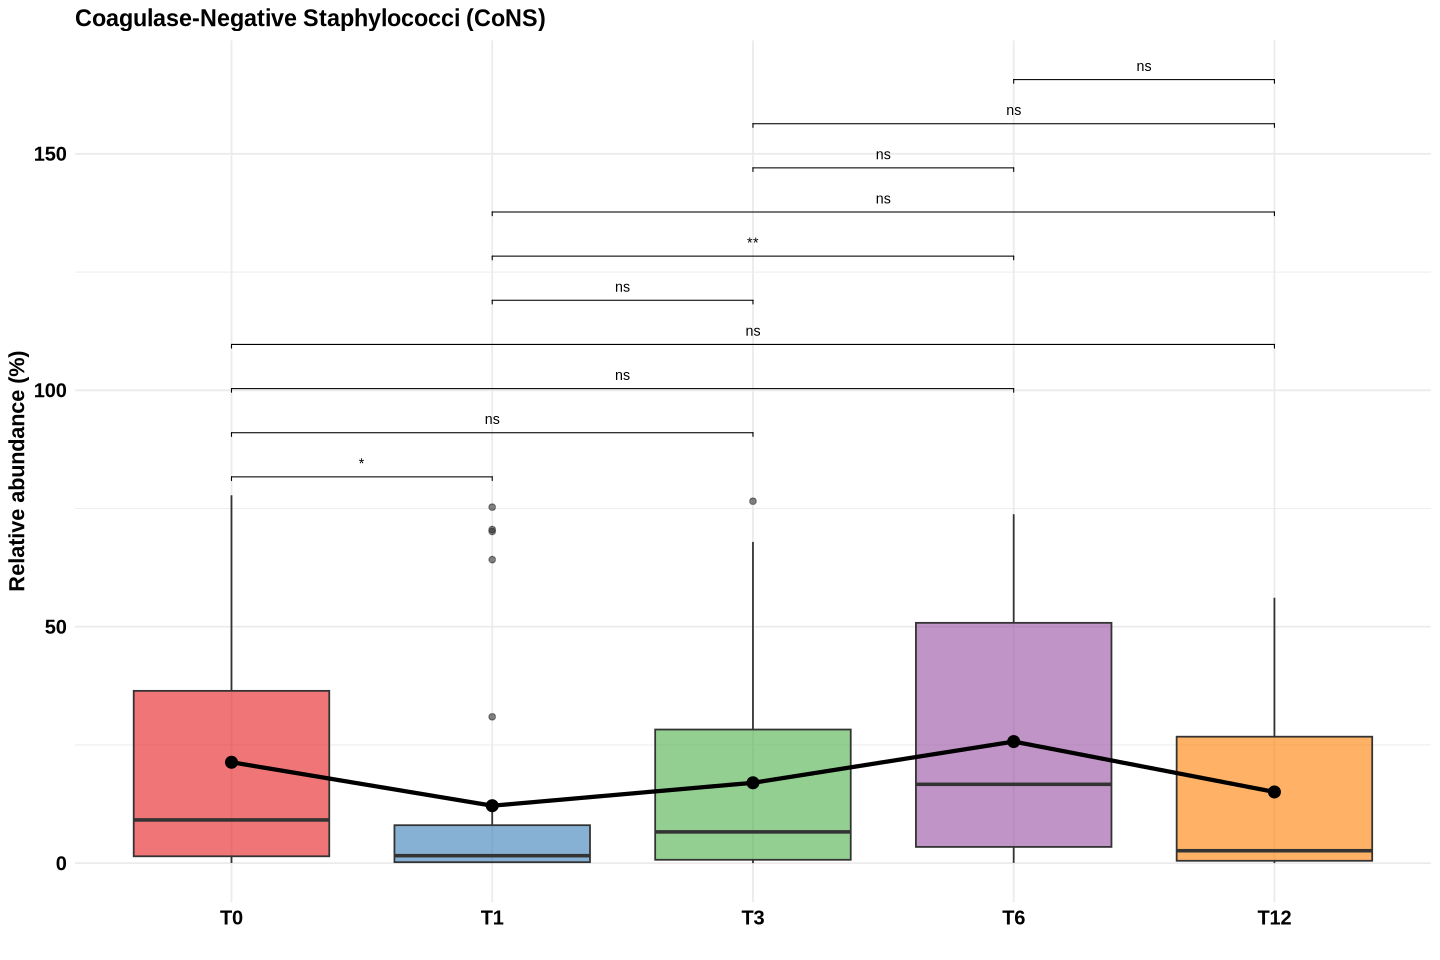

In [45]:
#### CoPS x CoNS
## Extract Genus + species (first two words from Taxa)
df_species <- df_species %>%
  mutate(Taxa_clean = str_extract(Taxa, "^\\S+\\s+\\S+"))

## Recalculate relative abundance per sample
df_species <- df_species %>%
  group_by(ID_Sample) %>%
  mutate(RelAbund = Counts / sum(Counts) * 100) %>%
  ungroup()

## Define species groups
cop_species <- c("Staphylococcus aureus")
cons_species <- c("Staphylococcus epidermidis", "Staphylococcus lugdunensis", "Staphylococcus haemolyticus")

### ---- CoP Staphylococcus Plot ---- ###
df_cop <- df_species %>%
  filter(Taxa_clean %in% cop_species) %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

means_cop <- df_cop %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

p_cop <- ggplot(df_cop, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_cop, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_cop, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  stat_compare_means(
    comparisons = my_comparisons,
    method = "wilcox.test",
    p.adjust.method = "bonferroni",
    label = "p.signif",
    tip.length = 0.01,
    size = 3
  ) +
  theme_minimal() +
  labs(
    title = "Coagulase-Positive Staphylococci (CoPS)",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text = element_text(size = 12, face = "bold", color = "black"),
    legend.position = "none"
  )


### ---- CoNS Staphylococcus Plot ---- ###
df_cons <- df_species %>%
  filter(Taxa_clean %in% cons_species) %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

means_cons <- df_cons %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

p_cons <- ggplot(df_cons, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_cons, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_cons, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  stat_compare_means(
    comparisons = my_comparisons,
    method = "wilcox.test",
    p.adjust.method = "bonferroni",
    label = "p.signif",
    tip.length = 0.01,
    size = 3
  ) +
  theme_minimal() +
  labs(
    title = "Coagulase-Negative Staphylococci (CoNS)",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text = element_text(size = 12, face = "bold", color = "black"),
    legend.position = "none"
  )

# Show both plots
p_cop
p_cons


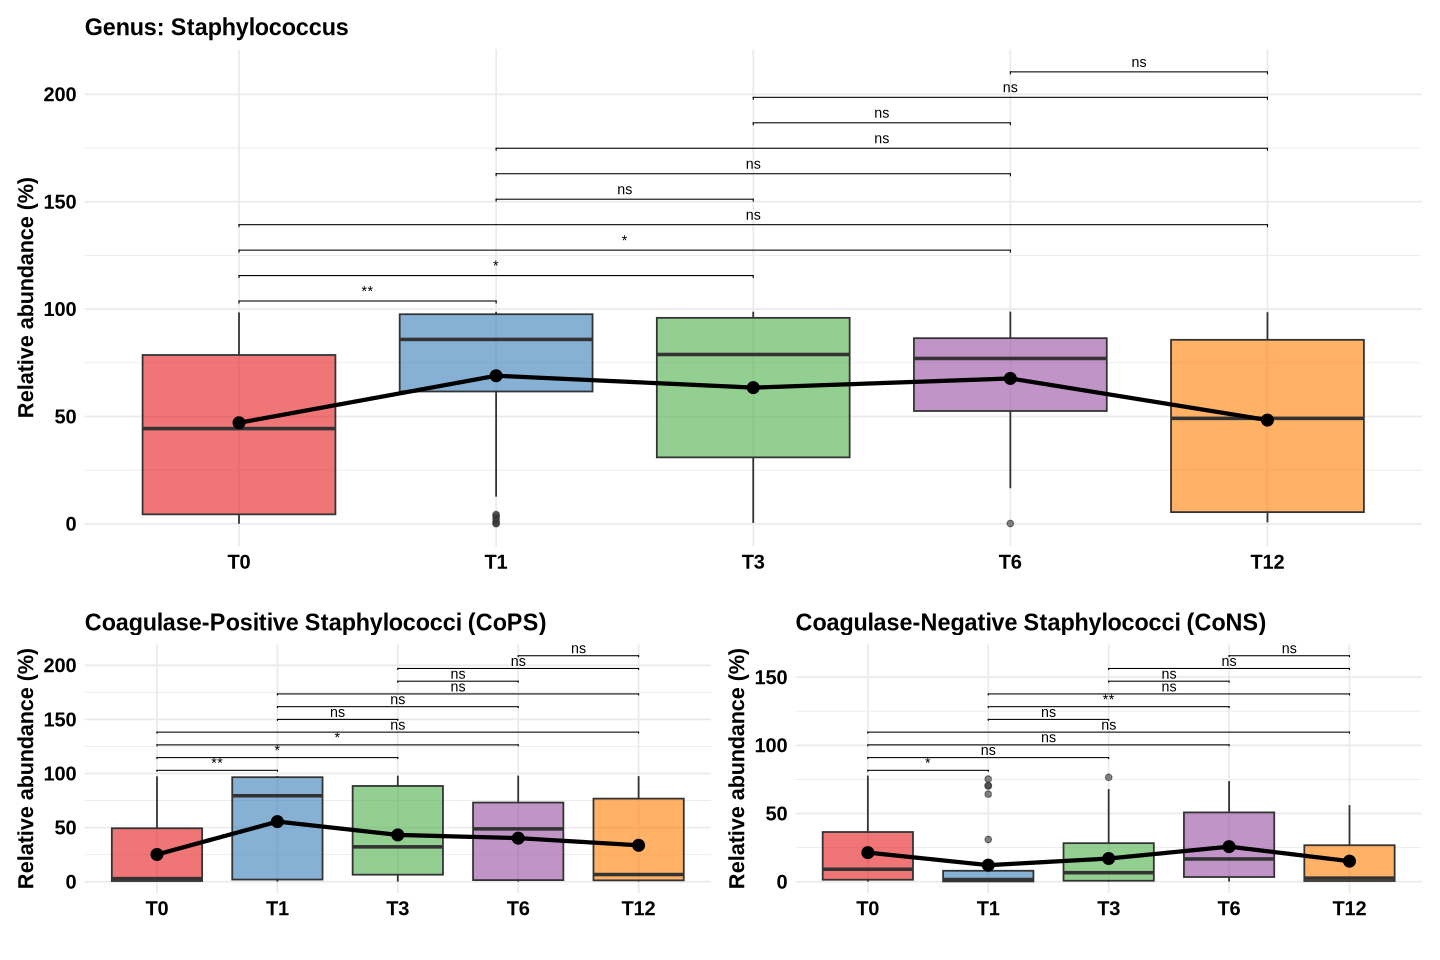

In [49]:
## Combine three plots in one
### Combine CoP and CoNS side-by-side
bottom_row <- p_cop + p_cons

### Stack the Staph plot on top and bottom row below, with relative heights
final_staph_plot <- p_staph_genus / bottom_row +
  plot_layout(heights = c(2, 1))  # 2:1 ratio (half vs quarter + quarter)

final_staph_plot

In [20]:
df_species[grep("Shigella", df_species$Taxa), ]

Taxa,ID_Sample,Timepoint,Counts,Genus,RelAbund
<chr>,<chr>,<fct>,<int>,<chr>,<dbl>
Shigella dysenteriae,0130765A_T0,T0,7,Shigella,0.207530388
Shigella flexneri,0130765A_T0,T0,7,Shigella,0.207530388
Shigella boydii ATCC 9905,0236549G_T0,T0,1,Shigella,0.022172949
Shigella dysenteriae,0878122D_T0,T0,7,Shigella,0.033352392
Shigella dysenteriae,1560534I_T0,T0,7,Shigella,0.041123252
Shigella dysenteriae,1562839D_T0,T0,7,Shigella,0.085013359
Shigella flexneri,1562839D_T0,T0,2,Shigella,0.024289531
Shigella boydii,1272679D_T12,T12,14,Shigella,0.716112532
Shigella dysenteriae,1272679D_T12,T12,14,Shigella,0.716112532


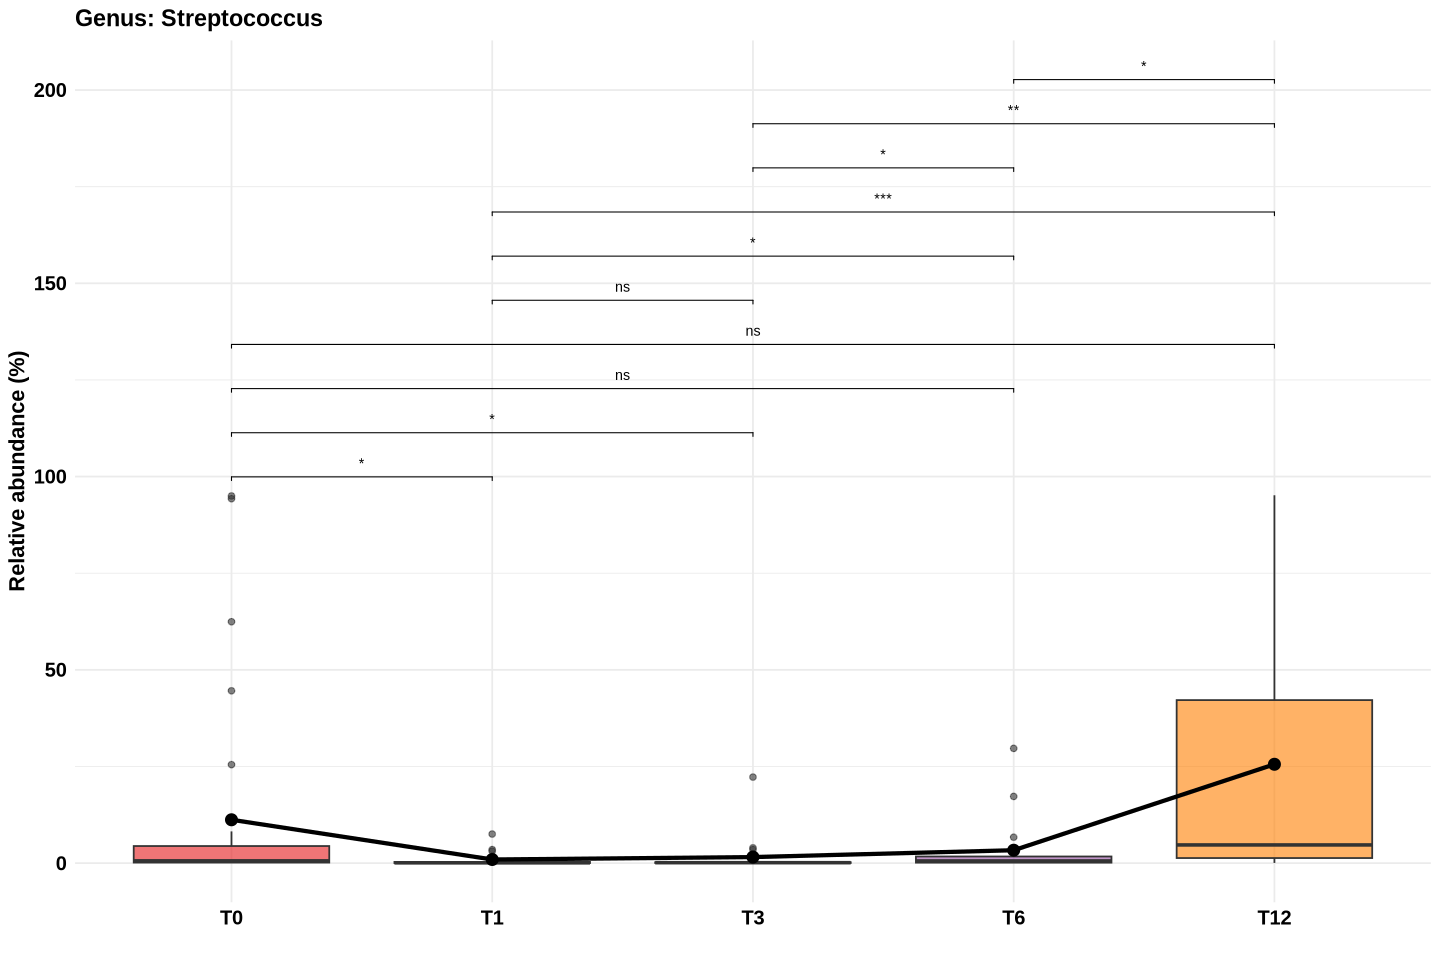

In [50]:
# Plot changes in the relative abundance of specific genus across timepoints
## Filter for Genus: Streptococcus
df_strepto <- df_species %>%
  filter(Genus == "Streptococcus")

## Sum relative abundance per sample across all Strepto species
df_strepto_genus <- df_strepto %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean
means_strepto <- df_strepto_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Plot Streptococcus spp.
p_strepto_genus <- ggplot(df_strepto_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_strepto, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_strepto, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  stat_compare_means(
    comparisons = my_comparisons,
    method = "wilcox.test",
    p.adjust.method = "bonferroni",
    label = "p.signif",
    tip.length = 0.01,
    size = 3
  ) +
  theme_minimal() +
  labs(
    title = "Genus: Streptococcus",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )
p_strepto_genus

Warning message in wilcox.test.default(c(0.384122919334187, 0.194258579753939, 0.118588793359028, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0297973778307509, 0.0364241856592778, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.207504755317309, 0.0818107444777748, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1.69680732306318, 0.893072652667149, 0.0687049124012367, :
“cannot compute exact p-value with ties”


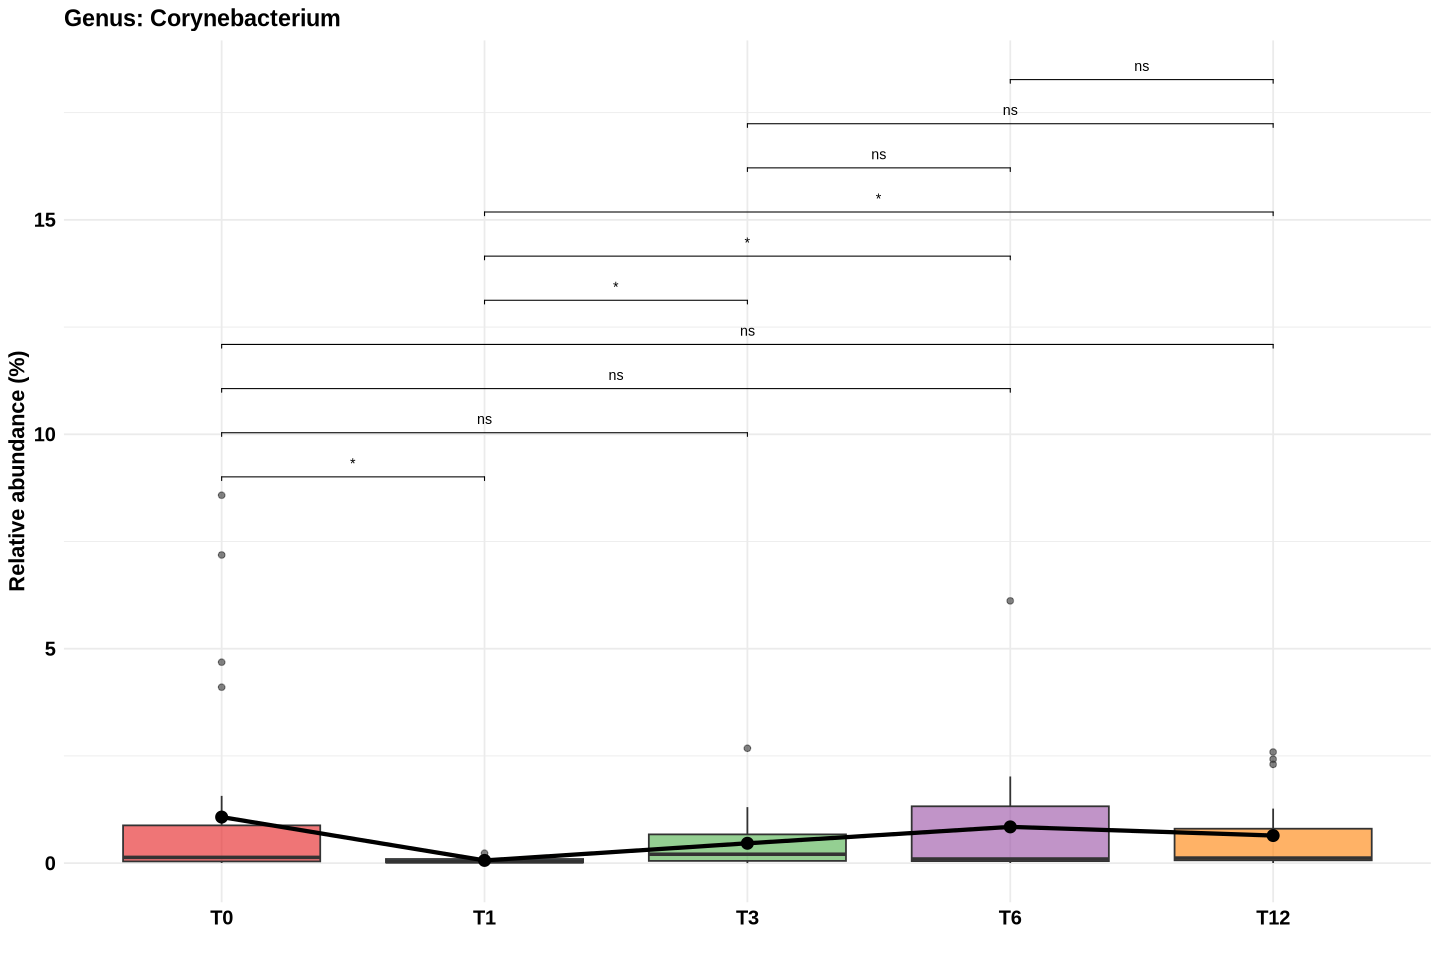

In [53]:
# Plot changes in the relative abundance of specific genus across timepoints
## Filter for Genus: Corynebacterium
df_coryne <- df_species %>%
  filter(Genus == "Corynebacterium")

## Sum relative abundance per sample across all Coryne species
df_coryne_genus <- df_coryne %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean
means_coryne <- df_coryne_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Plot Corynebacterium spp.
p_coryne_genus <- ggplot(df_coryne_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_coryne, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_coryne, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  stat_compare_means(
    comparisons = my_comparisons,
    method = "wilcox.test",
    p.adjust.method = "bonferroni",
    label = "p.signif",
    tip.length = 0.01,
    size = 3
  ) +
  theme_minimal() +
  labs(
    title = "Genus: Corynebacterium",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )
p_coryne_genus

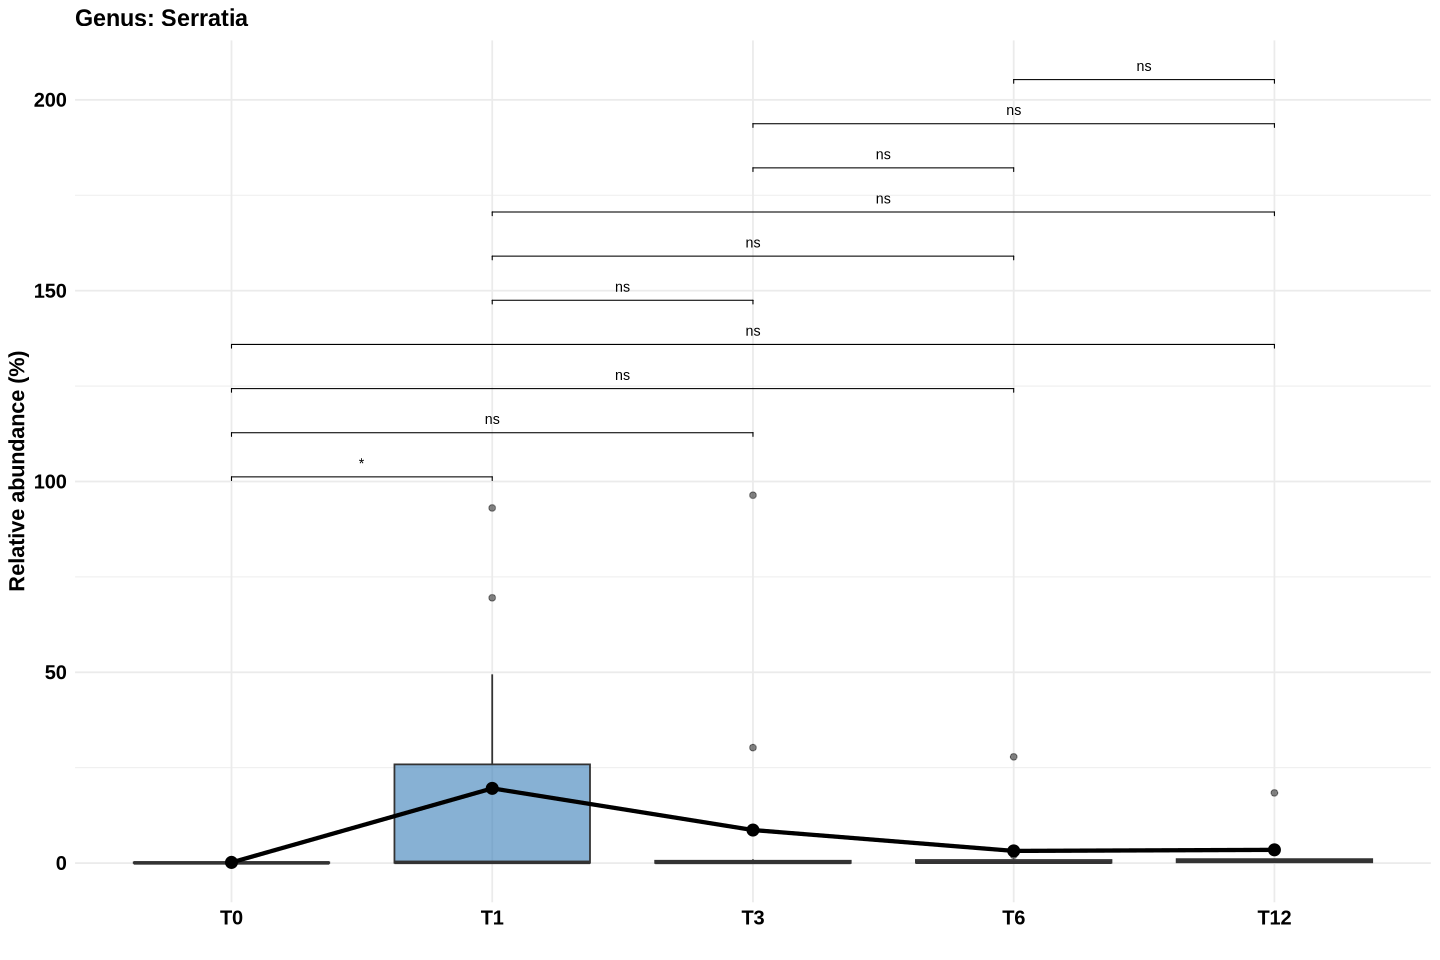

In [23]:
# Plot changes in the relative abundance of specific genus across timepoints
## Filter for Genus: Serratia
df_pseudo <- df_species %>%
  filter(Genus %in% c("Serratia"))

## Sum relative abundance per sample across all Coryne species
df_pseudo_genus <- df_pseudo %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean
means_pseudo <- df_pseudo_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Plot Corynebacterium spp.
p_pseudo_genus <- ggplot(df_pseudo_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_pseudo, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_pseudo, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  stat_compare_means(
    comparisons = my_comparisons,
    method = "wilcox.test",
    p.adjust.method = "bonferroni",
    label = "p.signif",
    tip.length = 0.01,
    size = 3
  ) +
  theme_minimal() +
  labs(
    title = "Genus: Serratia",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )
p_pseudo_genus

In [76]:
head(df_species)
write.table(df_species, file = "df_species.tsv", quote = FALSE, sep = "\t", row.names = F)

Taxa,ID_Sample,Timepoint,Counts,RelAbund,Taxa_clean,Genus
<chr>,<chr>,<fct>,<int>,<dbl>,<chr>,<chr>
[Propionibacterium] namnetense,0088303G_T0,T0,1,0.01600512,[Propionibacterium] namnetense,[Propionibacterium]
Anaerococcus octavius,0088303G_T0,T0,4,0.06402049,Anaerococcus octavius,Anaerococcus
bacterium,0088303G_T0,T0,8,0.12804097,NA,bacterium
bacterium 1-gw1-3,0088303G_T0,T0,9,0.14404609,bacterium 1-gw1-3,bacterium
bacterium HKG213,0088303G_T0,T0,16,0.25608195,bacterium HKG213,bacterium
bacterium N47,0088303G_T0,T0,21,0.33610755,bacterium N47,bacterium


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observat

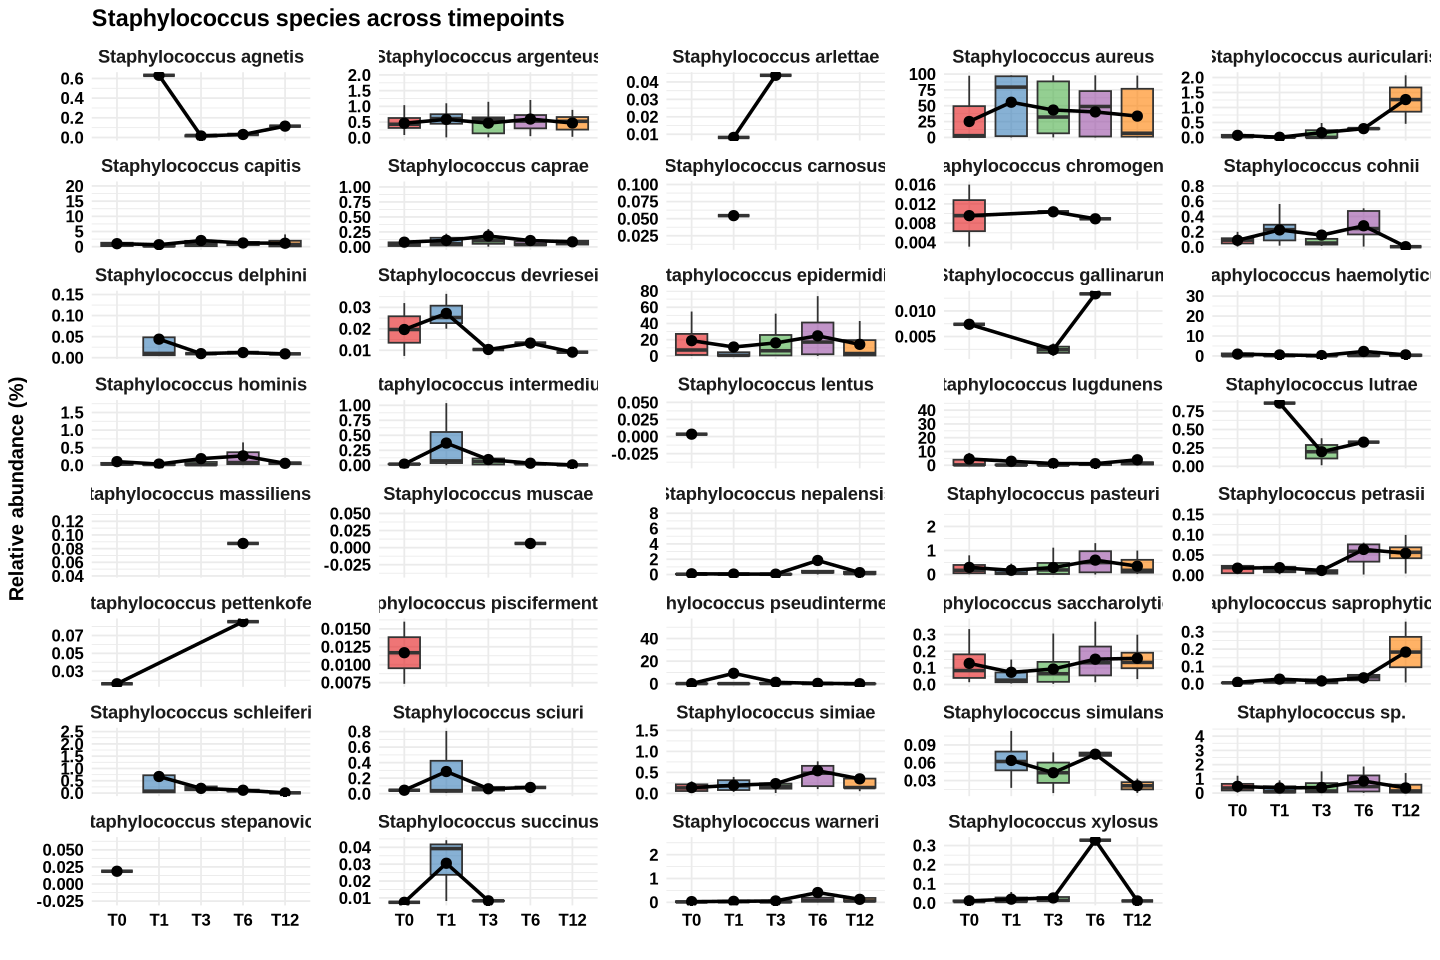

In [61]:
## Filter for Staphylococcus species
staph_species_plot <- df_species %>%
  filter(Genus == "Staphylococcus") %>%
  group_by(ID_Sample, Timepoint, Taxa_clean) %>%
  summarise(RelativeAbundance = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean for each species
means_species <- staph_species_plot %>%
  group_by(Timepoint, Taxa_clean) %>%
  summarise(Mean = mean(RelativeAbundance), .groups = "drop")

## Plot with facet per species
p_species_facet <- ggplot(staph_species_plot, aes(x = Timepoint, y = RelativeAbundance)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6, outlier.shape = NA) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 2.5, fill = "black") +
  geom_line(data = means_species, aes(x = Timepoint, y = Mean, group = Taxa_clean), color = "black", linewidth = 1) +
  geom_point(data = means_species, aes(x = Timepoint, y = Mean), color = "black", size = 2) +
  facet_wrap(~ Taxa_clean, scales = "free_y", ncol = 5) +
  theme_minimal() +
  labs(
    title = "Staphylococcus species across timepoints",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    strip.text = element_text(size = 11, face = "bold"),
    axis.text = element_text(size = 10, face = "bold", color = "black"),
    axis.title.y = element_text(size = 12, face = "bold"),
    plot.title = element_text(size = 14, face = "bold"),
    legend.position = "none"
  )

p_species_facet

ggsave("staph_abund_timepoints.png", p_species_facet, width = 12, height = 10, dpi = 300)

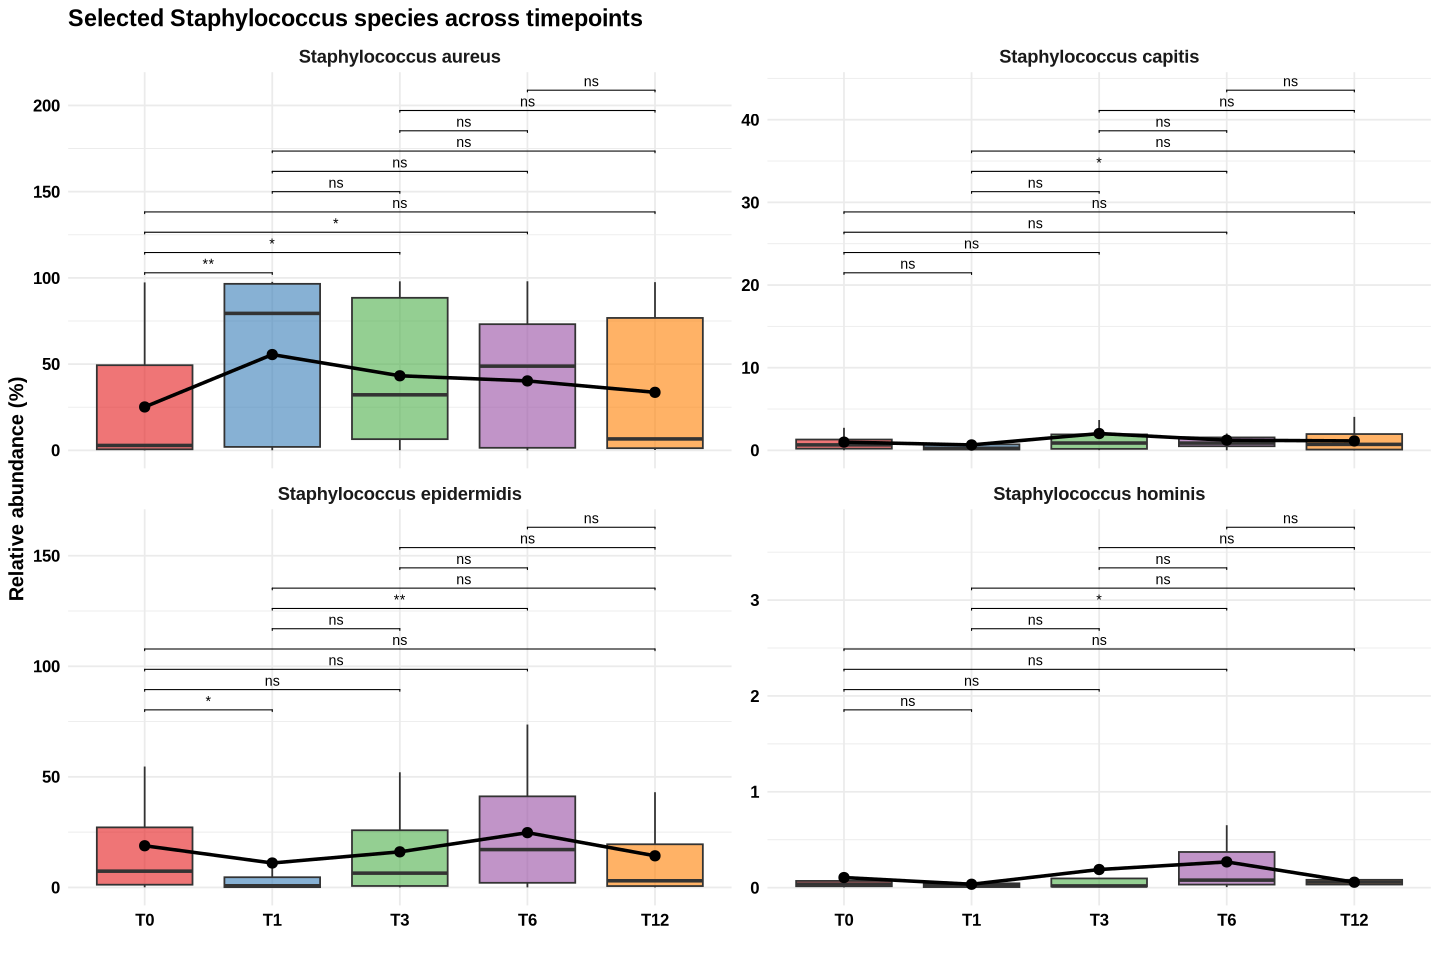

In [71]:
# Re-do plot with most interesting Staphspecies
## Define species of interest
interesting_species <- c(
  "Staphylococcus aureus",
  "Staphylococcus epidermidis",
  "Staphylococcus capitis", 
  "Staphylococcus hominis"
)

## Filter for Staphylococcus species of interest
staph_species_plot_filtered <- df_species %>%
  filter(Genus == "Staphylococcus", Taxa_clean %in% interesting_species) %>%
  group_by(ID_Sample, Timepoint, Taxa_clean) %>%
  summarise(RelativeAbundance = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean for each species
means_species_filtered <- staph_species_plot_filtered %>%
  group_by(Timepoint, Taxa_clean) %>%
  summarise(Mean = mean(RelativeAbundance), .groups = "drop")

# Define pairwise comparisons for timepoints
my_comparisons <- list(
  c("T0", "T1"), c("T0", "T3"), c("T0", "T6"), c("T0", "T12"),
  c("T1", "T3"), c("T1", "T6"), c("T1", "T12"),
  c("T3", "T6"), c("T3", "T12"),
  c("T6", "T12")
)

# Re-do plot with significance annotations
p_species_filtered <- ggplot(staph_species_plot_filtered, aes(x = Timepoint, y = RelativeAbundance)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6, outlier.shape = NA) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 2.5, fill = "black") +
  geom_line(data = means_species_filtered, aes(x = Timepoint, y = Mean, group = Taxa_clean), color = "black", linewidth = 1) +
  geom_point(data = means_species_filtered, aes(x = Timepoint, y = Mean), color = "black", size = 2) +
  facet_wrap(~ Taxa_clean, scales = "free_y", ncol = 2) +
  stat_compare_means(
    comparisons = my_comparisons,
    method = "wilcox.test",
    p.adjust.method = "bonferroni",
    label = "p.signif",
    tip.length = 0.01,
    size = 3
  ) +
  theme_minimal() +
  labs(
    title = "Selected Staphylococcus species across timepoints",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    strip.text = element_text(size = 11, face = "bold"),
    axis.text = element_text(size = 10, face = "bold", color = "black"),
    axis.title.y = element_text(size = 12, face = "bold"),
    plot.title = element_text(size = 14, face = "bold"),
    legend.position = "none"
  )

p_species_filtered

In [73]:
unique(staph_species_plot$Taxa_clean)

[1] "Staphylococcus argenteus"        "Staphylococcus aureus"          
 [3] "Staphylococcus epidermidis"      "Staphylococcus saccharolyticus" 
 [5] "Staphylococcus sp."              "Staphylococcus auricularis"     
 [7] "Staphylococcus capitis"          "Staphylococcus cohnii"          
 [9] "Staphylococcus gallinarum"       "Staphylococcus haemolyticus"    
[11] "Staphylococcus hominis"          "Staphylococcus lugdunensis"     
[13] "Staphylococcus nepalensis"       "Staphylococcus pasteuri"        
[15] "Staphylococcus petrasii"         "Staphylococcus saprophyticus"   
[17] "Staphylococcus simiae"           "Staphylococcus warneri"         
[19] "Staphylococcus xylosus"          "Staphylococcus pseudintermedius"
[21] "Staphylococcus schleiferi"       "Staphylococcus caprae"          
[23] "Staphylococcus chromogenes"      "Staphylococcus devriesei"       
[25] "Staphylococcus pettenkoferi"     "Staphylococcus piscifermentans" 
[27] "Staphylococcus sciuri"           "Staphylococcus succinus"        
[29] "Staphylococcus agnetis"          "Staphylococcus delphini"        
[31] "Staphylococcus intermedius"      "Staphylococcus lutrae"          
[33] "Staphylococcus simulans"         "Staphylococcus massiliensis"    
[35] "Staphylococcus muscae"           "Staphylococcus lentus"          
[37] "Staphylococcus arlettae"         "Staphylococcus stepanovicii"    
[39] "Staphylococcus carnosus"